## Initial Setup - Import libraries and input data 

In [35]:
%matplotlib inline

import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test

In [36]:
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/') #German macro dataset by H.lutkepohl
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
train = dta.loc['1960-04-01':'1978-10-01']#, ['dln_inv', 'dln_inc', 'dln_consump']] 
test = dta.loc['1979-01-01':]
#first 75 quarter as train data, rest 16 as test
#To convert raw data to first difference of ln use: np.log(dta['inv']).diff()
train.head()

,inv,inc,consump,qtr,ln_inv,dln_inv,ln_inc,dln_inc,ln_consump,dln_consump
qtr,,,,,,,,,,
1960-04-01,179,465,421,1960-04-01,5.187386,-0.005571,6.142037,0.030570,6.042633,0.014355
1960-07-01,185,485,434,1960-07-01,5.220356,0.032970,6.184149,0.042111,6.073044,0.030411
1960-10-01,192,493,448,1960-10-01,5.257495,0.037139,6.200509,0.016360,6.104793,0.031749
1961-01-01,211,509,459,1961-01-01,5.351858,0.094363,6.232448,0.031939,6.129050,0.024257
1961-04-01,202,520,458,1961-04-01,5.308268,-0.043591,6.253829,0.021381,6.126869,-0.002181


## Visualizing the raw and the transformed data

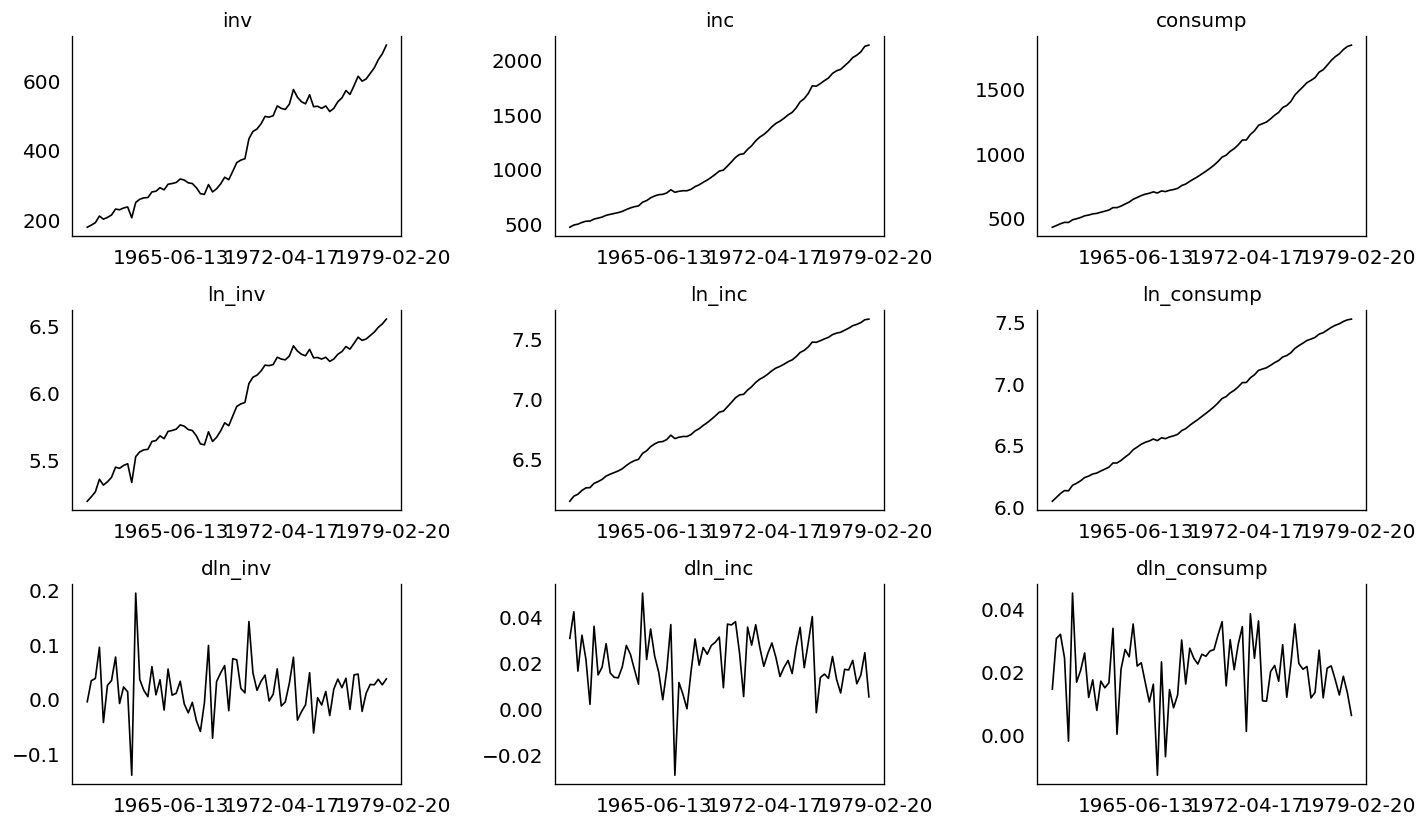

In [37]:
# Plot
ls=['inv','inc','consump','ln_inv','ln_inc','ln_consump', 'dln_inv','dln_inc','dln_consump']
df=train[ls]
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

## Stationarity Test - ADF Test

In [38]:
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



inv: ADF test results:
ADF Statistic: 0.238053
p-value: 0.974317
Critical Values:
	5%: -2.904


inc: ADF test results:
ADF Statistic: 4.956163
p-value: 1.000000
Critical Values:
	5%: -2.901


consump: ADF test results:
ADF Statistic: 1.757540
p-value: 0.998261
Critical Values:
	5%: -2.903


ln_inv: ADF test results:
ADF Statistic: -0.678588
p-value: 0.852218
Critical Values:
	5%: -2.904


ln_inc: ADF test results:
ADF Statistic: -0.815066
p-value: 0.814656
Critical Values:
	5%: -2.901


ln_consump: ADF test results:
ADF Statistic: 0.090957
p-value: 0.965438
Critical Values:
	5%: -2.903


dln_inv: ADF test results:
ADF Statistic: -2.766930
p-value: 0.063155
Critical Values:
	5%: -2.904


dln_inc: ADF test results:
ADF Statistic: -8.166436
p-value: 0.000000
Critical Values:
	5%: -2.901


dln_consump: ADF test results:
ADF Statistic: -3.152453
p-value: 0.022907
Critical Values:
	5%: -2.903


## VAR MODEL

In [39]:
exog = train['dln_consump']
mod = sm.tsa.VARMAX(train[['dln_inv', 'dln_inc']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                             VAR(1)   Log Likelihood                 333.024
Date:                    Thu, 08 Jul 2021   AIC                           -652.049
Time:                            16:35:19   BIC                           -635.826
Sample:                        04-01-1960   HQIC                          -645.571
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                66.67, 63.88   Jarque-Bera (JB):         12.21, 13.05
Prob(Q):                        0.01, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.39, 0.65   Skew:                      0.14, -0.46
Prob(H) (two-sided):            0.02, 0.30   Kurtosis:                   4.96, 4.83


In [40]:
start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index)

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])


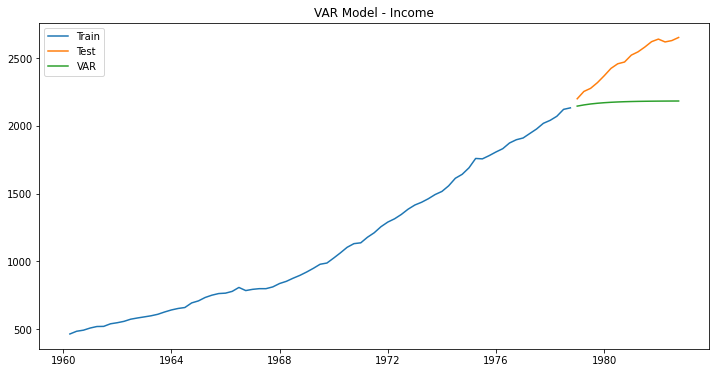

In [41]:
plt.figure(figsize=(12,6)) 
plt.plot( train['inc'], label='Train')
plt.plot(test['inc'], label='Test')
plt.plot(predictions['inc'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

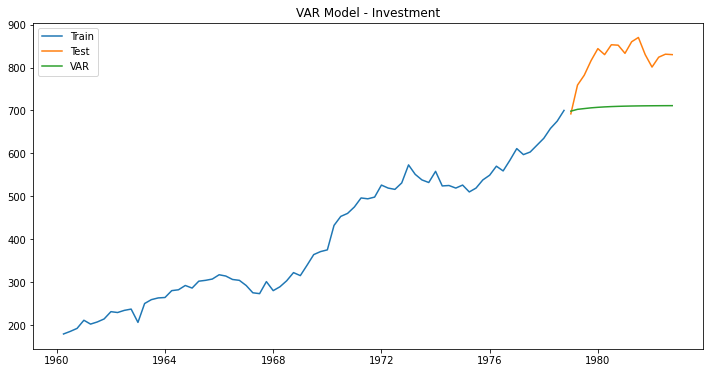

In [42]:
plt.figure(figsize=(12,6))
plt.plot(train['inv'], label='Train')
plt.plot(test['inv'], label='Test')
plt.plot(predictions['inv'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

In [43]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.inc, predictions.inc)).round(2)
#print('Income: RMSE:',  rmse)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Income'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.inv, predictions.inv)).round(2)
#print('Investment: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='Investment'
append.loc[0,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(test.inc-predictions.inc)
actual = test.inc
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Income: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='Income', 'MAPE'] = mape

abs_error = np.abs(test.inv-predictions.inv)
actual = test.inv
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('Investment: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='Investment', 'MAPE'] = mape

In [44]:
model_comparison.reset_index(drop=True, inplace=True)
model_comparison

,Model,Variable,RMSE,MAPE
0,VAR,Income,329.41,11.83
1,VAR,Investment,117.97,13.43


## Cointegration - Johansen Test

In [45]:
"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [46]:
joh_model1 = coint_johansen(dta[['ln_inv','ln_inc','ln_consump']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     43.030857   58.047480
1      9.355569   15.016623
2      5.661054    5.661054 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



Note that the test-statistics at each stage for both trace test and max eigen test are greater than the test statistic at 5% significance level. 
SO THE RANK OF THE MATRIX IS 2 => NO COINTEGRATION => VAR IN DIFFERENCE IS SUFFICIENT FOR THESE 3 SERIES.

## VARMAX MODEL

In [47]:
exog = train['dln_consump']
mod = sm.tsa.VARMAX(train[['dln_inv', 'dln_inc']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model 
#The VAR model has AIC = -665, while the VARMAX model has AIC = -713
#So including the MA components, and the exogenous variable, consumption, imporved our forecast

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                        VARMAX(1,1)   Log Likelihood                 369.448
Date:                    Thu, 08 Jul 2021   AIC                           -712.896
Time:                            16:35:23   BIC                           -682.769
Sample:                        04-01-1960   HQIC                          -700.867
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                65.61, 23.14   Jarque-Bera (JB):          13.46, 0.52
Prob(Q):                        0.01, 0.98   Prob(JB):                   0.00, 0.77
Heteroskedasticity (H):         0.45, 0.75   Skew:                      0.24, -0.20
Prob(H) (two-sided):            0.05, 0.48   Kurtosis:                   5.02, 2.88


In [48]:
start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['dln_consump']])

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])


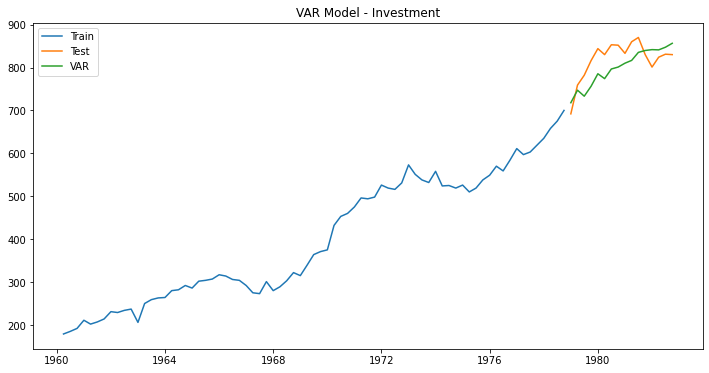

In [49]:
plt.figure(figsize=(12,6))
plt.plot(train['inv'], label='Train')
plt.plot(test['inv'], label='Test')
plt.plot(predictions['inv'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

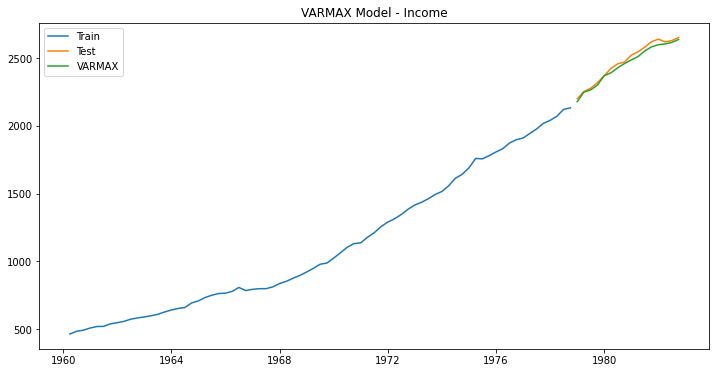

In [50]:
plt.figure(figsize=(12,6)) 
plt.plot( train['inc'], label='Train')
plt.plot(test['inc'], label='Test')
plt.plot(predictions['inc'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - Income')
plt.show()

In [51]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.inc, predictions.inc)).round(2)

model_comparison1=pd.DataFrame()
model_comparison1.loc[0,'Model']='VARMAX'
model_comparison1.loc[0,'Variable']='Income'
model_comparison1.loc[0,'RMSE']=rmse
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test.inv, predictions.inv)).round(2)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='Investment'
append.loc[0,'RMSE']=rmse

model_comparison1=model_comparison1.append(append)
#print('Investment: RMSE:',  rmse)

# Mean Absolute Percentage Error
abs_error = np.abs(test.inc-predictions.inc)
actual = test.inc
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison1.loc[model_comparison1['Variable']=='Income', 'MAPE'] = mape

#print('Income: MAPE:',  mape)
abs_error = np.abs(test.inv-predictions.inv)
actual = test.inv
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison1.loc[model_comparison1['Variable']=='Investment', 'MAPE'] = mape
#print('Investment: MAPE:',  mape)
model_comparison.append(model_comparison1)

,Model,Variable,RMSE,MAPE
0,VAR,Income,329.41,11.83
1,VAR,Investment,117.97,13.43
0,VARMAX,Income,25.08,0.88
0,VARMAX,Investment,40.11,4.40


## Impulse Response Function

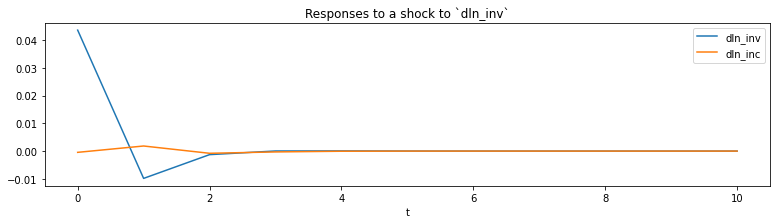

In [52]:
ax = res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `dln_inv`');

# VARMAX Model(Self)

In [55]:
exog = train['dln_consump']
mod = sm.tsa.VARMAX(train[['dln_inv', 'dln_inc']], order=(1,1), trend='n', exog=exog) #order(AR,MA)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                        VARMAX(1,1)   Log Likelihood                 369.448
Date:                    Thu, 08 Jul 2021   AIC                           -712.896
Time:                            16:38:22   BIC                           -682.769
Sample:                        04-01-1960   HQIC                          -700.867
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                65.61, 23.14   Jarque-Bera (JB):          13.46, 0.52
Prob(Q):                        0.01, 0.98   Prob(JB):                   0.00, 0.77
Heteroskedasticity (H):         0.45, 0.75   Skew:                      0.24, -0.20
Prob(H) (two-sided):            0.05, 0.48   Kurtosis:                   5.02, 2.88


In [56]:
start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['dln_consump']])

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])
